In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [2]:
df = pd.read_csv("Analisis_sentimen_timnas_sepakbola_indonesia_di_era_STY.csv")

In [3]:
df.head()

,komentar,label
0,<username> Simulasi indonesia kembali dijajah ...,negatif
1,<username> <username> <username> keturunan lai...,negatif
2,<username> <username> uda botak keturunan penj...,negatif
3,"<username> <username> <username> Belum tentu, ...",negatif
4,<username> <username> <username> Lu nya aja yg...,negatif


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   komentar  398 non-null    object
 1   label     398 non-null    object
dtypes: object(2)
memory usage: 6.3+ KB


# Menghapus Data Duplicated

In [5]:
# Menghapus baris yang duplikat berdasarkan kolom 'komentar'
df_clean = df.drop_duplicates(subset=['komentar'])

In [6]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393 entries, 0 to 397
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   komentar  393 non-null    object
 1   label     393 non-null    object
dtypes: object(2)
memory usage: 9.2+ KB


# Cleanning

In [7]:
import re
import pandas as pd

def clean_text(text):
    # 1. Menghapus username tag (<username>)
    text = re.sub(r'<username>', ' ', text)
    
    # 2. Menghapus URL (jika ada)
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text, flags=re.MULTILINE)
    
    # 3. Menghapus karakter khusus dan angka
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    
    # 4. Menghapus whitespace berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 5. Mengubah ke lowercase
    text = text.lower()
    
    return text

# Menerapkan fungsi cleaning ke kolom komentar
df['cleaned_komentar'] = df['komentar'].apply(clean_text)

# Menampilkan hasil sebelum dan sesudah cleaning
print("Sebelum cleaning:")
print(df['komentar'].head())
print("\nSetelah cleaning:")
print(df['cleaned_komentar'].head())

Sebelum cleaning:
0    <username> Simulasi indonesia kembali dijajah ...
1    <username> <username> <username> keturunan lai...
2    <username> <username> uda botak keturunan penj...
3    <username> <username> <username> Belum tentu, ...
4    <username> <username> <username> Lu nya aja yg...
Name: komentar, dtype: object

Setelah cleaning:
0    simulasi indonesia kembali dijajah keturunan b...
1    keturunan lain yang gak main bola emang bisa d...
2    uda botak keturunan penjajah sok si paling pah...
3    belum tentu gak semuanya jadi pemain bola dan ...
4    lu nya aja yg bego makanya nonton sendiri tolo...
Name: cleaned_komentar, dtype: object


# Preprocessing

In [8]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk

# Download resource NLTK
nltk.download('punkt')
nltk.download('stopwords')

# Inisialisasi tools
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_words = set(stopwords.words('indonesian'))
custom_stopwords = ['yg', 'aja', 'lu', 'nya', 'sih', 'dong', 'deh']
stop_words.update(custom_stopwords)

# Kamus normalisasi slang
slang_dict = {'gak': 'tidak', 'ga': 'tidak', 'nggak': 'tidak', 'lu': 'anda', 'gw': 'saya'}
negation_words = ['tidak', 'bukan', 'jangan', 'tak']

def preprocess_text(text):
    # 1. Normalisasi slang
    words = text.split()
    words = [slang_dict[word] if word in slang_dict else word for word in words]
    
    # 2. Handle negation
    for i, word in enumerate(words):
        if word in negation_words and i+1 < len(words):
            words[i+1] = word + "_" + words[i+1]
    text = ' '.join(words)
    
    # 3. Tokenisasi
    tokens = word_tokenize(text)
    
    # 4. Stopword removal
    tokens = [word for word in tokens if word not in stop_words]
    
    # 5. Stemming
    tokens = [stemmer.stem(word) for word in tokens]
    
    return ' '.join(tokens)

# Terapkan preprocessing ke kolom 'cleaned_komentar'
df['processed_text'] = df['cleaned_komentar'].apply(preprocess_text)

# Hasil preprocessing
print("Hasil Preprocessing:")
print(df[['cleaned_komentar', 'processed_text']].head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Hasil Preprocessing:
                                    cleaned_komentar  \
0  simulasi indonesia kembali dijajah keturunan b...   
1  keturunan lain yang gak main bola emang bisa d...   
2  uda botak keturunan penjajah sok si paling pah...   
3  belum tentu gak semuanya jadi pemain bola dan ...   
4  lu nya aja yg bego makanya nonton sendiri tolo...   

                                      processed_text  
0  simulasi indonesia jajah turun belanda depan b...  
1  turun tidak main bola emang naturalisasi istim...  
2  uda botak turun jajah sok si paham bola coach ...  
3  tidak semua main bola milih karir main bola ku...  
4  bego nonton tolol persepsi orang beda tidak ha...  


# EDA

In [9]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Fungsi untuk membuat wordcloud terpisah
def create_wordcloud(text, title, figsize=(10, 5)):
    plt.figure(figsize=figsize)
    wordcloud = WordCloud(width=800, height=400, 
                         background_color='white').generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.show()

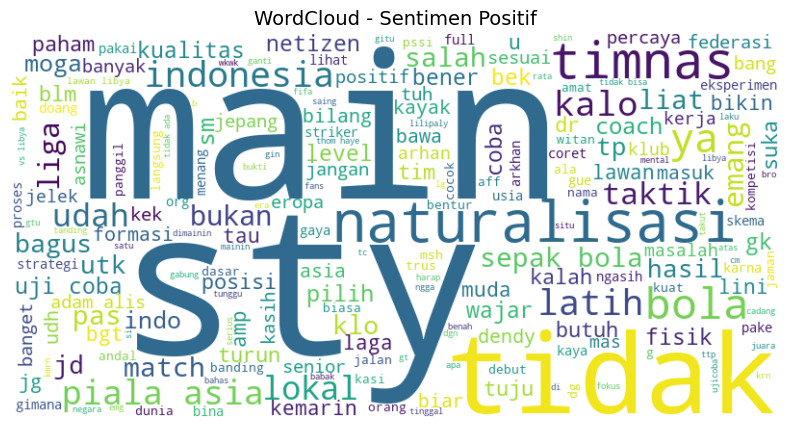

In [10]:
# WordCloud Sentimen Positif
text_positif = ' '.join(df[df['label']=='positif']['processed_text'])
create_wordcloud(text_positif, 'WordCloud - Sentimen Positif')

Berdasarkan word cloud analisis sentimen positif terhadap Timnas Indonesia di era STY (Shin Tae-yong), terlihat dominasi kata-kata optimis seperti "timnas", "bagus", "bola", "naturalisasi", "coach", dan "latih" yang mencerminkan antusiasme publik terhadap transformasi sepakbola nasional. Fenomena ini sejalan dengan performa nyata di lapangan, dimana Indonesia berhasil mencapai babak ketiga Kualifikasi Piala Dunia 2026 untuk pertama kalinya dalam sejarah, didukung oleh strategi naturalisasi pemain keturunan yang kontroversial namun efektif seperti Eliano Reijnders dan Ragnar Oratmangoen. Secara sosial, era STY telah mengubah persepsi masyarakat dari skeptisisme menjadi optimisme, terbukti dari meningkatnya antusiasme penonton di stadion dan engagement media sosial yang positif, meskipun masih terdapat perdebatan mengenai identitas nasional dalam konteks naturalisasi - namun sentiment analysis ini menunjukkan bahwa mayoritas publik lebih

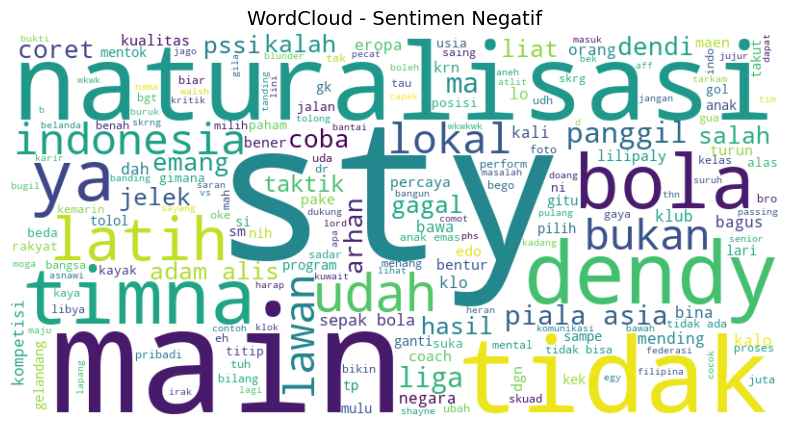

In [11]:
# WordCloud Sentimen Negatif
text_negatif = ' '.join(df[df['label']=='negatif']['processed_text'])
create_wordcloud(text_negatif, 'WordCloud - Sentimen Negatif')

Analisis sentimen negatif terhadap Timnas Indonesia di era STY mengungkapkan kritik yang tajam melalui dominasi kata-kata seperti "tidak", "main", "ya", "sudah", "lokal", dan "dendy" yang mencerminkan kekecewaan publik terhadap aspek-aspek tertentu dalam pengelolaan tim nasional. Sentimen ini berkorelasi dengan beberapa kontroversi di lapangan, termasuk keputusan kontroversial pelatih dalam rotasi pemain, ketergantungan berlebihan pada pemain naturalisasi yang dinilai mengesampingkan talenta lokal, serta performa inkonsisten dalam beberapa pertandingan penting yang memicu kritik media dan suporter. Secara sosial, polarisasi ini mencerminkan dilema identitas sepakbola Indonesia modern, dimana sebagian masyarakat merasa terasing dengan komposisi tim yang semakin didominasi pemain keturunan, ditambah dengan ekspektasi tinggi yang tidak selalu terpenuhi dalam setiap laga - menciptakan dinamika love-hate relationship antara publik dengan program naturalisasi dan strategi pelatih, yang pada akhirnya menunjukkan bahwa meskipun prestasi meningkat, proses transformasi sepakbola nasional masih menghadapi resistensi dan skeptisisme dari sebagian kalangan yang menginginkan pendekatan yang lebih mengutamakan pengembangan pemain domestik.

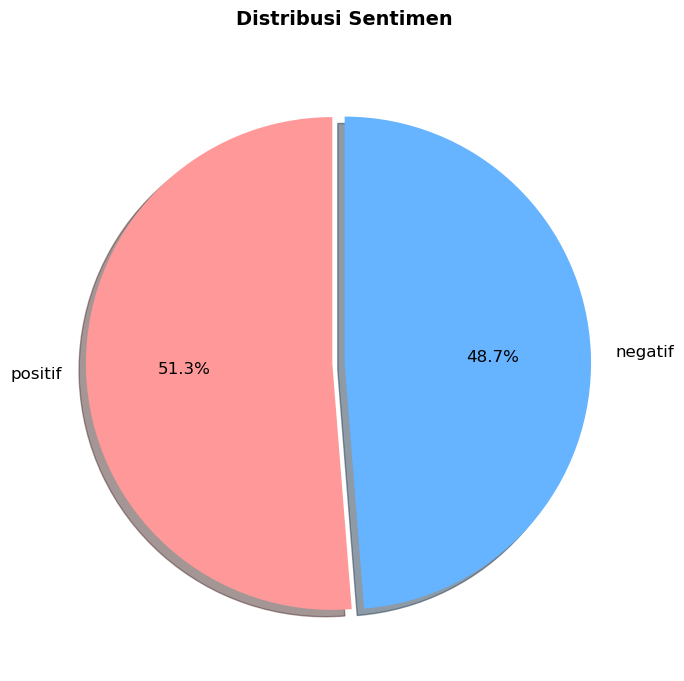

In [12]:
import matplotlib.pyplot as plt

# Hitung distribusi sentimen
sentiment_counts = df['label'].value_counts()

# Siapkan data untuk pie chart
labels = sentiment_counts.index.tolist()
values = sentiment_counts.values.tolist()
colors = ['#ff9999','#66b3ff']  # Warna untuk setiap bagian

# Buat pie chart
plt.figure(figsize=(8, 8))
plt.pie(values, 
        labels=labels, 
        colors=colors, 
        autopct='%1.1f%%',
        startangle=90, 
        shadow=True, 
        explode=(0.05, 0) if len(values) == 2 else (0.05, 0, 0),  # Sesuaikan berdasarkan jumlah sentimen
        textprops={'fontsize': 12})
plt.title('Distribusi Sentimen\n', fontsize=14, fontweight='bold')
plt.show()

Distribusi sentimen publik terhadap Timnas Indonesia di era STY menunjukkan polarisasi yang hampir seimbang dengan sentimen positif tipis mengungguli negatif (51.3% vs 48.7%), mencerminkan kondisi transisi sepakbola nasional yang masih dalam fase adaptasi dan evaluasi masyarakat. Margin tipis ini mengindikasikan bahwa meskipun prestasi historis seperti lolos ke babak ketiga Kualifikasi Piala Dunia 2026 dan kemenangan-kemenangan penting telah meningkatkan optimisme, namun kontroversi seputar kebijakan naturalisasi, inkonsistensi performa, dan keputusan taktis pelatih masih memicu perdebatan yang intens di kalangan penggemar sepakbola. Secara sosiologis, kondisi ini menggambarkan fenomena "cautious optimism" dimana masyarakat Indonesia mulai percaya pada kemajuan timnas namun tetap kritis dan waspada, mencerminkan trauma historis dari kegagalan-kegagalan masa lalu yang membuat publik tidak mudah terbawa euforia - sebuah sikap yang sebenarnya sehat dalam mendorong akuntabilitas dan perbaikan berkelanjutan dalam ekosistem sepakbola nasional.

# Model

In [13]:
# 4. Label Encoding
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

In [14]:
# 5. Train-Test Split
X = df['processed_text']
y = df['label_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [15]:
# 6. Tokenization and Padding
max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [16]:
# 7. Model LSTM
embedding_dim = 128

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # 3 kelas: negatif, netral, positif

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

D:\Annaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [17]:
# 8. Training dengan Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train_pad, y_train,
                    epochs=20,  # Jumlah epoch
                    batch_size=64,
                    validation_data=(X_test_pad, y_test),
                    callbacks=[early_stop])

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.4733 - loss: 1.0802 - val_accuracy: 0.5000 - val_loss: 0.9194
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.4824 - loss: 0.9048 - val_accuracy: 0.7000 - val_loss: 0.6906
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5563 - loss: 0.7499 - val_accuracy: 0.6000 - val_loss: 0.6716
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5147 - loss: 0.7378 - val_accuracy: 0.5750 - val_loss: 0.6745
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6053 - loss: 0.7019 - val_accuracy: 0.6750 - val_loss: 0.6356
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6119 - loss: 0.6470 - val_accuracy: 0.5750 - val_loss: 0.6756
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6885 - loss: 0.6349 - val_accuracy: 0.7000 - val_loss: 0.6186
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7565 - loss: 0.5502 - val_accuracy: 0.7000 - val_loss: 0.6331

In [18]:
# 9. Evaluasi Model
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7333 - loss: 0.6010
Test Accuracy: 0.7250


Dari hasil pelatihan model pada gambar tersebut, terlihat bahwa akurasi pelatihan meningkat konsisten hingga mencapai 97% pada epoch ke-13, menunjukkan model sangat baik dalam menghafal pola dari data latih. Namun, akurasi validasi justru stagnan dan cenderung fluktuatif antara 60–72%, dengan loss validasi bahkan meningkat di akhir pelatihan. Selain itu, akurasi uji pada data nyata hanya mencapai 72.5%, jauh di bawah akurasi pelatihan. Hal ini menunjukkan indikasi overfitting, di mana model terlalu fokus pada data pelatihan dan kurang mampu beradaptasi terhadap data baru. Dalam konteks dunia nyata, situasi ini menggambarkan fenomena kebijakan atau sistem yang "bagus di atas kertas" namun gagal saat diimplementasikan secara luas, misalnya kurikulum pendidikan yang sangat teoritis namun tidak membekali siswa dengan keterampilan praktis untuk menghadapi dunia kerja. Ini menekankan pentingnya validasi berbasis konteks sosial dan kebutuhan riil agar solusi yang dibangun benar-benar bermanfaat dan aplikatif di lapangan.

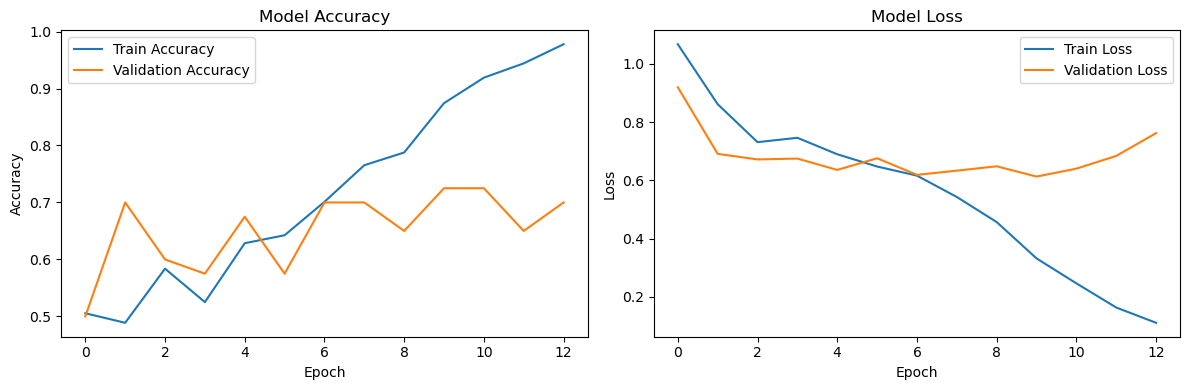

In [19]:
# 10. Visualisasi Akurasi dan Loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

Berdasarkan grafik performa model di atas, terlihat bahwa akurasi pada data pelatihan terus meningkat secara signifikan dari epoch ke-1 hingga ke-12, sementara akurasi validasi cenderung stagnan dan fluktuatif setelah epoch ke-6. Di sisi lain, grafik loss menunjukkan bahwa loss pelatihan menurun tajam, sedangkan loss validasi justru mulai meningkat setelah epoch ke-6. Pola ini menandakan bahwa model mengalami overfitting, yaitu terlalu menyesuaikan diri dengan data pelatihan sehingga kehilangan kemampuan generalisasi terhadap data baru. Dalam konteks lapangan dan sosial, fenomena ini mencerminkan situasi di mana suatu sistem atau kebijakan dibuat sangat ideal di atas kertas atau dalam kondisi laboratorium, namun gagal beradaptasi dengan kompleksitas dan dinamika nyata di masyarakat. Misalnya, sebuah program pelatihan kerja yang sangat efektif dalam simulasi pelatihan internal bisa jadi tidak memberikan dampak signifikan ketika diterapkan pada masyarakat luas karena tidak mempertimbangkan variasi kebutuhan, latar belakang, dan kondisi sosial ekonomi peserta. Hal ini menekankan pentingnya validasi di dunia nyata dan adaptasi berbasis konteks lapangan.

# Thank you